In [1]:
import os
from glob import glob
import shutil
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tff
from skimage.io import imsave

In [2]:
# imgPath = '/Users/zhengj10/Desktop/iGABASnFR/Dish_1/'
imgPath = '/Users/zhengj10/Desktop/210513/'

os.path.exists(imgPath)


True

In [3]:
# imgFiles = glob(imgPath+'/*.mat')
# imgFiles = sorted(imgFiles)
# len(imgFiles)
imgFile = imgPath+'test_image_FOV_00004.tif'


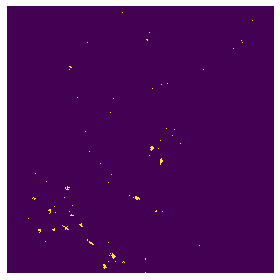

In [4]:
imgData = tff.TiffFile(imgFile)
imgData = imgData.asarray()
imgData = imgData[500:2900,:,:]
img_norm = (imgData/imgData[0])-1

act_pix = []
for i in range(10,2390):
    a = (np.mean(img_norm[i+1:i+10,:,:],axis=0)-np.mean(img_norm[i-10:i,:,:],axis=0))>0.04
    act_pix.append(a)
act_pix = np.array(act_pix)
act_pix = np.max(act_pix,axis=0)
plt.axis('off')
plt.tight_layout()
plt.imshow(act_pix)


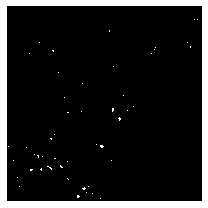

In [25]:
fig = plt.figure(figsize=[3,3])
plt.imshow(act_pix,cmap='gray')
plt.axis('off')
plt.tight_layout()
fig.savefig(imgPath+'act_pix.png')

In [6]:
from skimage import measure
contours = measure.find_contours(act_pix, 0.1)

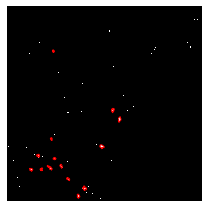

In [26]:
fig = plt.figure(figsize=[3,3])
plt.imshow(act_pix,cmap='gray')
thre = 20 # Exclude small ROIs
# roi = 0
for contour in contours:
    if contour.shape[0]>thre:
#         roi+=1
        plt.plot(contour[:,1], contour[:, 0], color = 'r',lw=1)
plt.axis('off')
plt.tight_layout()
fig.savefig(imgPath+'roi.png')


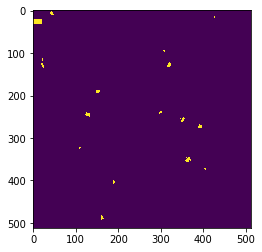

In [8]:
from matplotlib.path import Path
mean_image = imgData[0,:,:]
# plt.figure(figsize=[12,12])
plt.imshow(np.zeros([512,512]))
coordinates = []
for r in range(act_pix.shape[0]):
    for c in range(act_pix.shape[1]):
        coordinates.append([r,c])
coordinates = np.array(coordinates)

meanImg_b0 = []
rois = []
for contour in contours:
    if contour.shape[0]>thre:
        p = Path(contour)
        roi = p.contains_points(coordinates)
        roi = roi.reshape(512,512)
        f0 = np.sum(roi*mean_image)/np.sum(roi)
        rois.append(roi)
        meanImg_b0.append(roi*mean_image)


x = np.arange(0, 20)
y = np.arange(22, 32)
xv, yv = np.meshgrid(x, y)
mask = np.zeros(mean_image.shape)
mask[yv.flatten().astype(np.int), xv.flatten().astype(np.int)] = 1
rois.append(mask) # Add mask (fb)
meanImg_b0.append(rois[-1]*mean_image) # Add mask (fb)
rois_all = np.sum(rois,axis=0)      
        
plt.imshow(rois_all)
meanImg_b0 = np.sum(meanImg_b0,axis=0)
# plt.colorbar()
plt.show()


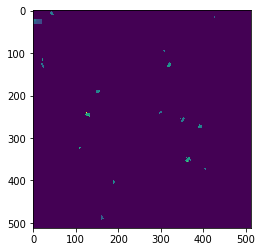

In [9]:
# plt.figure(figsize=[12,12])
plt.imshow(meanImg_b0)
# plt.colorbar()
plt.show()


In [10]:
len(rois)
# imgData.shape

17

In [1]:
Fb = np.min(imgData[-1,:,:])
F0 = np.mean(imgData[:10,:,:],axis=0)
fig = plt.figure(figsize=[12,(len(rois)-1)/15])
i = 1
x = np.arange(1,2401)
for roi in range(len(rois)-1):
    if roi in [1,2]:
        continue
    offset = 0.05*i
    dFF_all = []
    for frame in range(imgData.shape[0]):
        F_single = np.sum(rois[roi]*imgData[frame,:,:])/np.sum(rois[roi])
        dFF = (F_single - np.sum(rois[roi]*F0)/np.sum(rois[roi]))/(np.sum(rois[roi]*F0)/np.sum(rois[roi])-Fb)
        dFF_all.append(dFF)
    dFF_all = np.array(dFF_all)
    dFF_all = signal.detrend(dFF_all)
#     b, a = signal.butter(8, 0.4)
    dFF_all = signal.filtfilt(b, a, dFF_all, padlen=125)
    plt.fill_between(x,dFF_all - offset, 0 - offset, 
                 zorder=i+1, 
                 facecolor='w', edgecolor='w', 
                 lw=0, 
                 closed=True)
    plt.plot(x,dFF_all - offset, zorder=i+1, color='k', lw=0.5)
    plt.axis('off')
    i+=1
# plt.plot([2350,2450,2450],[-1.1,-1.1,-0.9],color='k',alpha=0.8)
plt.tight_layout()
# fig.savefig('/Users/zhengj10/Desktop/dFF_013.pdf',format='pdf')21


NameError: name 'np' is not defined

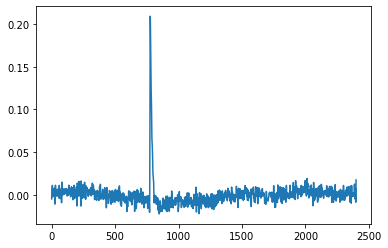

In [33]:
b, a = signal.butter(8, 0.4)
y = signal.filtfilt(b, a, dFF_all, padlen=125)
plt.plot(y)
plt.show()

In [21]:
from scipy import signal

dFF_all_d = signal.detrend(dFF_all)

In [ ]:
fig = plt.figure(figsize=[15,12])
subplot_no=1
imgData_act_pix_all = {}
for imgFile in imgFiles:
    print(imgFile)
    imgData_act_pix_all[imgFile] = []
    imgData = loadmat(imgFile)
    imgData = imgData['data']
    imgData = imgData[:,0][500:2900]
    imgData_aslist = []
    for i in range(imgData.shape[0]):
        imgData_aslist.append(imgData[i])
    imgData = np.array(imgData_aslist)
    img_norm = (imgData/imgData[0])-1
    act_pix = []
    for i in range(10,2390):
        a = (np.mean(img_norm[i+1:i+10,:,:],axis=0)-np.mean(img_norm[i-10:i,:,:],axis=0))>0.04
        act_pix.append(a)
    act_pix = np.array(act_pix)
    act_pix = np.max(act_pix,axis=0)
    ax = plt.subplot(4,5,subplot_no)
    ax.imshow(act_pix,cmap='gray')
    imgData_act_pix_all[imgFile].append(act_pix)
    subplot_no+=1
fig.savefig('/Users/zhengj10/Desktop/210203/act_pix.png')

In [ ]:
fig = plt.figure(figsize=[15,12])
subplot_no=1
for imgFile in imgFiles:
    print(imgFile)
    imgData = loadmat(imgFile)
    imgData = imgData['data']
    imgData = imgData[:,0][500]
    ax = plt.subplot(4,5,subplot_no)
    ax.imshow(imgData,cmap='gray',vmin=1500,vmax=5000)
    ax.axis('off')

    subplot_no+=1
plt.tight_layout()
# fig.savefig(imgPath + 'all_FOVs.png')

In [ ]:
import pickle

with open('act_pixel.pickle', 'wb') as handle:
    pickle.dump(imgData_act_pix_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('act_pixel.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [ ]:
img_1 = np.zeros((32,32))
img_2 = np.zeros((32,32))

In [ ]:
img_1[12,15] = 5
img_2[15,12] = 2
plt.imshow(img_1,cmap='gray')
plt.imshow(img_2,cmap='gray',alpha=0.5)